# Rebuild estimation of feature count from using a grid method

#### Parameters that **have to be** adjustable:

- Size of the grid (i.e. how large is the side of each square)
- Size of the counting square (i.e. how large is the side of each counting square). To consider:
    - Size relative to grid square? Percentage of grid square side or of grid square area?
    - or make its size absolute? --> min > 0 & max = grid square side

### Parameters that **should** adjustable:

- inclusion / exclusion criteria:
    - on which sides of the square / cube is a ROI included / excluded
- position of the counting square:
    - upper left, upper center, upper right
    - middle left, middle center, middle right
    - lower left, lower center, lower right

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import measure
from shapely.geometry import Polygon, LineString
from shapely.validation import make_valid
import roifile

from typing import Dict, Tuple, List, Optional

### Classes:

In [2]:
class CountingSquare:
    
    def __init__(self, size: int, position: str, corners: Dict):
        self.size = size
        self.position = position
        self.all_corner_coords = corners
        self.bounding_box_roi = Polygon([corners['upper_left'], 
                                         corners['upper_right'], 
                                         corners['lower_right'], 
                                         corners['lower_left']])
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    
    def set_in_and_exclusion_sides(self, sides: List[str], passed_in_or_exclusion_sides: str='exclusion') -> None:
        self._assert_valid_input(sides = sides, passed_in_or_exclusion_sides = passed_in_or_exclusion_sides)
        if passed_in_or_exclusion_sides == 'exclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'exclusion')
        elif passed_in_or_exclusion_sides == 'inclusion':
            in_and_exclusion_attributes = self._derive_in_and_exclusion_attributes(sides = sides, in_or_exclusion = 'inclusion')
        for in_or_exclusion_key in ['inclusion', 'exclusion']:
            for attribute_key in ['as_strings', 'as_lines']:
                setattr(self, f'{in_or_exclusion_key}_sides_{attribute_key}', in_and_exclusion_attributes[in_or_exclusion_key][attribute_key])
            
    
    def _assert_valid_input(self, sides: List[str], passed_in_or_exclusion_sides: str) -> None:
        sides_error_message = '"sides" has to be a list of two string elements, which can be any of these: "upper", "right", "lower", "left" - no duplicates!'
        if type(sides) == list:
            if len(sides) != 2:
                raise ValueError(sides_error_message)
            if sides[0] == sides[1]:
                raise ValueError()
            for elem in sides:
                if type(elem) != str:
                    raise TypeError(sides_error_message)
                if elem not in ['upper', 'right', 'lower', 'left']:
                    raise ValueError(sides_error_message)
        else:
            raise TypeError(sides_error_message)
        in_or_exclusion_error_message = '"passed_in_or_exclusion_sides" has to be either "exclusion" or "inclusion".'
        if type(passed_in_or_exclusion_sides) == str:
            if passed_in_or_exclusion_sides not in ['exclusion', 'inclusion']:
                raise ValueError(in_or_exclusion_error_message)
        else:
            raise TypeError(in_or_exclusion_error_message)             
    
           
    def _derive_in_and_exclusion_attributes(self, sides: List[str], in_or_exclusion: str) -> Dict:
        in_and_exclusion_attributes = {'inclusion': {},
                                       'exclusion': {}}
        in_and_exclusion_attributes[in_or_exclusion]['as_strings'] = sides
        in_and_exclusion_attributes[in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in sides]
        remaining_sides = ['upper', 'right', 'lower', 'left']
        for side_string in sides:
            remaining_sides.remove(side_string)
        if in_or_exclusion == 'inclusion':
            remaining_in_or_exclusion = 'exclusion'
        else:
            remaining_in_or_exclusion = 'inclusion'
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_strings'] = remaining_sides
        in_and_exclusion_attributes[remaining_in_or_exclusion]['as_lines'] = [self._construct_line_shape_from_side_string(side_string) for side_string in remaining_sides]        
        return in_and_exclusion_attributes
    
    
    def _construct_line_shape_from_side_string(self, side_string: str) -> LineString:
        corner_point_keys = list(self.all_corner_coords.keys())
        corners = [key for key in corner_point_keys if side_string in key]
        starting_point_coords = self.all_corner_coords[corners[0]]
        end_point_coords = self.all_corner_coords[corners[1]]
        return LineString([starting_point_coords, end_point_coords])

In [3]:
class ImageTile:
    
    def __init__(self, tiles_row_id: int, tiles_col_id: int, tile: np.ndarray):
        self.row_id = tiles_row_id
        self.col_id = tiles_col_id
        self.image = tile
        self.height, self.width = tile.shape[0:2]
        self.all_corner_coords = self._calculate_all_corner_coords()
        self.bounding_box_roi = self._convert_corner_coords_to_bounding_box_roi()
        self.bounding_box_x_for_plotting = self.bounding_box_roi.boundary.xy[1]
        self.bounding_box_y_for_plotting = self.bounding_box_roi.boundary.xy[0]
        
    def _convert_corner_coords_to_bounding_box_roi(self):
        coords = self.all_corner_coords
        return Polygon([coords['upper_left'], coords['upper_right'], coords['lower_right'], coords['lower_left']])
    
    def _calculate_all_corner_coords(self) -> Dict:
        upper_left = (self.row_id * self.height, self.col_id * self.width)
        shape = (self.height, self.width)
        all_corner_coords = self._corners_from_upper_left_corner_and_shape(upper_left = upper_left, shape = shape)
        return all_corner_coords
    
    def _corners_from_upper_left_corner_and_shape(self, upper_left: Tuple[int, int], shape: Tuple[int, int]) -> Dict:
        all_corner_coords = {}
        all_corner_coords['upper_left'] = upper_left
        all_corner_coords['upper_right'] = (upper_left[0], upper_left[1] + shape[1])
        all_corner_coords['lower_left'] = (upper_left[0] + shape[0], upper_left[1])
        all_corner_coords['lower_right'] = (upper_left[0] + shape[0], upper_left[1] + shape[1])   
        return all_corner_coords
    
    def create_counting_square(self, size: int, position: str, sides_to_exclude: List[str]):
        self._ensure_counting_square_fits_within_tile(size = size)
        counting_square_upper_left_corner_coords = self._get_upper_left_corner_coords_by_position(size = size, position = position)
        all_corners_counting_square = self._corners_from_upper_left_corner_and_shape(upper_left = counting_square_upper_left_corner_coords,
                                                                                     shape = (size, size))
        self.counting_square = CountingSquare(size = size, position = position, corners = all_corners_counting_square)
        self.counting_square.set_in_and_exclusion_sides(sides = sides_to_exclude)
        
    
    def _ensure_counting_square_fits_within_tile(self, size: int):
        if (size > self.height) or (size > self.width):
            error_message_line_1 = 'The "size" you have chosen for the counting square is too large!\n'
            error_message_line_2 = f'It has to fit within your grid with height = {self.height} and width = {self.width}.\n'
            error_message_line_3 = f'Thus, the max value you could select for "size" is {min(self.height, self.width)}.'
            error_message = error_message_line_1 + error_message_line_2 + error_message_line_3
            raise ValueError(error_message)
        
        
    def _get_upper_left_corner_coords_by_position(self, size: int, position: str) -> Tuple[int, int]:
        upper_row = self.all_corner_coords['upper_left'][0]
        middle_row = upper_row + int(self.height * 0.5) - int(size * 0.5)
        lower_row = self.all_corner_coords['lower_left'][0] - size
        left_col = self.all_corner_coords['upper_left'][1]
        center_col = left_col + int(self.width * 0.5) - int(size * 0.5)
        right_col = self.all_corner_coords['upper_right'][1] - size
        if position == 'upper left':
            return (upper_row, left_col)
        elif position == 'upper center':
            return (upper_row, center_col)
        elif position == 'upper right':
            return (upper_row, right_col)
        elif position == 'middle left':
            return (middle_row, left_col)
        elif position == 'middle center':
            return (middle_row, center_col)
        elif position == 'middle right':
            return (middle_row, right_col)
        elif position == 'lower left':
            return (lower_row, left_col)
        elif position == 'lower center':
            return (lower_row, center_col)
        elif position == 'lower right':
            return (lower_row, right_col)
        else:
            raise ValueError(f'Please double-check the "position" you passed.')

### Functions:

In [4]:
"""
# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
def resize_image_and_create_tiles(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    if len(image.shape) == 3:
        image_height, image_width, image_channels = image.shape # might crash with grayscale images?
        tile_height, tile_width = tile_size
        if (image_height % tile_height != 0) or (image_width % tile_width != 0):
            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)
            image_height, image_width, image_channels = image.shape
        tiles = image.reshape(image_height // tile_height,
                              tile_height,
                              image_width // tile_width,
                              tile_width, 
                              image_channels)
        tiles = tiles.swapaxes(1,2)
    else:
        image_height, image_width = image.shape # might crash with grayscale images?
        tile_height, tile_width = tile_size
        if (image_height % tile_height != 0) or (image_width % tile_width != 0):
            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)
            image_height, image_width = image.shape
        tiles = image.reshape(image_height // tile_height,
                              tile_height,
                              image_width // tile_width,
                              tile_width)
        tiles = tiles.swapaxes(1,2)        
    return image, tiles


def _resize_image_for_tiles_by_padding_bottom_right(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image.shape[:2]
    pixels_required_for_height = tile_size[0] - image_height % tile_size[0]
    pixels_required_for_width = tile_size[1] - image_width % tile_size[1]
    if len(image.shape) == 3:
        return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width), (0, 0)))
    else:
        return np.pad(image, ((0, pixels_required_for_height), (0, pixels_required_for_width)))
"""


'\n# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7\ndef resize_image_and_create_tiles(image: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:\n    if len(image.shape) == 3:\n        image_height, image_width, image_channels = image.shape # might crash with grayscale images?\n        tile_height, tile_width = tile_size\n        if (image_height % tile_height != 0) or (image_width % tile_width != 0):\n            image = _resize_image_for_tiles_by_padding_bottom_right(image = image, tile_size = tile_size)\n            image_height, image_width, image_channels = image.shape\n        tiles = image.reshape(image_height // tile_height,\n                              tile_height,\n                              image_width // tile_width,\n                              tile_width, \n                              image_channels)\n        tiles = tiles.swapaxes(1,2)\n    else:\n        image_height, image_width = im

In [5]:
# from utils

def listdir_nohidden(path: Path) -> List:
    return [f for f in os.listdir(path) if f.startswith('.') == False]


def load_zstack_as_array_from_single_planes(path: Path, file_id: str, 
                                            minx: Optional[int]=None, maxx: Optional[int]=None, 
                                            miny: Optional[int]=None, maxy: Optional[int]=None) -> np.ndarray:
    types = list(set([type(minx), type(maxx), type(miny), type(maxy)]))    
    if any([minx, maxx, miny, maxy]):
        if (len(types) == 1) & (types[0] == int):
            cropping = True
        else:
            raise TypeError("'minx', 'maxx', 'miny', and 'maxy' all have to be integers - or None if no cropping has to be done")
    else:
        cropping = False
    filenames = [filename for filename in listdir_nohidden(path) if filename.startswith(file_id)]
    cropped_zstack = list()
    for single_plane_filename in filenames:
        tmp_image = imread(path.joinpath(single_plane_filename))
        if cropping:
            tmp_image = tmp_image[minx:maxx, miny:maxy]
        cropped_zstack.append(tmp_image.copy())
        del tmp_image
    return np.asarray(cropped_zstack)


def get_polygon_from_instance_segmentation(single_plane: np.ndarray, label_id: int) -> Polygon:
    x_dim, y_dim = single_plane.shape
    tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
    tmp_array[np.where(single_plane == label_id)] = 1
    tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
    roi = Polygon(tmp_contours)
    if roi.is_valid == False:
        roi = make_valid(roi)
    return roi

In [6]:
# adapted from: https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
def resize_grayscale_image_stack_and_create_tiles(image_stack: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image_stack.shape[1], image_stack.shape[2]
    tile_height, tile_width = tile_size
    if (image_height % tile_height != 0) or (image_width % tile_width != 0):
        image_stack = _resize_image_stack_for_tiles_by_padding_bottom_right(image_stack = image_stack, tile_size = tile_size)
        image_height, image_width  = image_stack.shape[1], image_stack.shape[2]
    representative_plane = image_stack[0]
    tiles = representative_plane.reshape(image_height // tile_height,
                                         tile_height,
                                         image_width // tile_width,
                                         tile_width)
    tiles = tiles.swapaxes(1,2)      
    return image_stack, tiles


def _resize_image_stack_for_tiles_by_padding_bottom_right(image_stack: np.ndarray, tile_size: Tuple[int, int]) -> np.ndarray:
    image_height, image_width = image_stack[0].shape
    pixels_required_for_height = tile_size[0] - image_height % tile_size[0]
    pixels_required_for_width = tile_size[1] - image_width % tile_size[1]
    return np.pad(image_stack, ((0,0), (0, pixels_required_for_height), (0, pixels_required_for_width)))

## Testing:

In [7]:
mask_zstack = load_zstack_as_array_from_single_planes(path = Path('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/instance_segmentations/'), file_id = '0000')
mask_zstack_to_quantify_for_grid_estimation = mask_zstack.copy()
mask_zstack_to_quantify_for_grid_estimation.shape

(13, 5568, 4189)

In [8]:
loaded_roi = roifile.ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/findmycells_projects/dummy_data/0000.roi')
row_coords = loaded_roi.coordinates()[:, 1]
col_coords = loaded_roi.coordinates()[:, 0]
area_roi = Polygon(np.asarray(list(zip(row_coords, col_coords))))

In [9]:
resized_mask_zstack, tiles = resize_grayscale_image_stack_and_create_tiles(image_stack = mask_zstack_to_quantify_for_grid_estimation, tile_size = (500, 500))
resized_mask_zstack.shape

(13, 6000, 4500)

In [10]:
overlapping_tiles = []
for row_id in range(tiles.shape[0]):
    for col_id in range(tiles.shape[1]):
        selected_tile = ImageTile(tiles_row_id = row_id, tiles_col_id = col_id, tile = tiles[row_id, col_id])
        if (selected_tile.bounding_box_roi.overlaps(area_roi)) or (selected_tile.bounding_box_roi.within(area_roi)):
            selected_tile.create_counting_square(size = 250, position = 'middle center', sides_to_exclude = ['right', 'lower'])
            overlapping_tiles.append(selected_tile)

In [11]:
# to speed up things - can I pass a list of label_ids and set them all to 0 in np.where?

all_label_id_matching_results = {}

label_ids_in_exclusion_plane = list(np.unique(resized_mask_zstack[-1]))
if 0 in label_ids_in_exclusion_plane:
    label_ids_in_exclusion_plane.remove(0)
if 0.0 in label_ids_in_exclusion_plane:
    label_ids_in_exclusion_plane.remove(0.0)
for label_id in label_ids_in_exclusion_plane:
    resized_mask_zstack[np.where(resized_mask_zstack == label_id)] = 0
    mask_zstack_to_quantify_for_grid_estimation[np.where(mask_zstack_to_quantify_for_grid_estimation == label_id)] = 0

for plane_id in range(resized_mask_zstack.shape[0]):
    print(f'Processing plane {plane_id + 1}/{resized_mask_zstack.shape[0]}')
    single_plane = resized_mask_zstack[plane_id]
    unique_label_ids = list(np.unique(single_plane))
    if 0 in unique_label_ids:
        unique_label_ids.remove(0)
    if 0.0 in unique_label_ids:
        unique_label_ids.remove(0.0)
    for label_id in unique_label_ids:
        all_label_id_matching_results[label_id] = {'overlapping_counting_squares': [],
                                                   'intersection_with_exclusion_lines': []}
        roi = get_polygon_from_instance_segmentation(single_plane = single_plane, label_id = label_id)
        for tile in overlapping_tiles:
            if roi.overlaps(tile.counting_square.bounding_box_roi) or roi.within(tile.counting_square.bounding_box_roi):
                if tile.counting_square not in all_label_id_matching_results[label_id]['overlapping_counting_squares']:
                    if len(all_label_id_matching_results[label_id]['overlapping_counting_squares']) > 0:
                        print(f'Warning: {label_id} overlaps with multiple counting squares! This case is actually not properly dealt with yet!') 
                    all_label_id_matching_results[label_id]['overlapping_counting_squares'].append(tile.counting_square)
                    # set to False per default
                    all_label_id_matching_results[label_id]['intersection_with_exclusion_lines'].append(False)
                lookup_index = all_label_id_matching_results[label_id]['overlapping_counting_squares'].index(tile.counting_square)
                if (roi.intersects(tile.counting_square.exclusion_sides_as_lines[0]) or
                    roi.intersects(tile.counting_square.exclusion_sides_as_lines[1])):
                    all_label_id_matching_results[label_id]['intersection_with_exclusion_lines'][lookup_index] = True


for label_id in all_label_id_matching_results.keys():
    overlaps_with_at_least_one_counting_square = len(all_label_id_matching_results[label_id]['overlapping_counting_squares']) > 0
    is_included_for_at_least_one_counting_square = False in all_label_id_matching_results[label_id]['intersection_with_exclusion_lines']
    if overlaps_with_at_least_one_counting_square & is_included_for_at_least_one_counting_square:
        continue
    else:
        mask_zstack_to_quantify_for_grid_estimation[np.where(mask_zstack_to_quantify_for_grid_estimation == label_id)] = 0

Processing plane 1/13
Processing plane 2/13
Processing plane 3/13
Processing plane 4/13
Processing plane 5/13
Processing plane 6/13
Processing plane 7/13
Processing plane 8/13
Processing plane 9/13
Processing plane 10/13
Processing plane 11/13
Processing plane 12/13
Processing plane 13/13


In [14]:
import cc3d

In [15]:
_, feature_count = cc3d.connected_components(mask_zstack, return_N=True)
features_per_area = feature_count / area_roi.area

In [17]:
_, feature_count_grid = cc3d.connected_components(mask_zstack_to_quantify_for_grid_estimation, return_N=True)
total_area = len(overlapping_tiles) * overlapping_tiles[0].counting_square.bounding_box_roi.area
features_per_area_grid = feature_count_grid / total_area

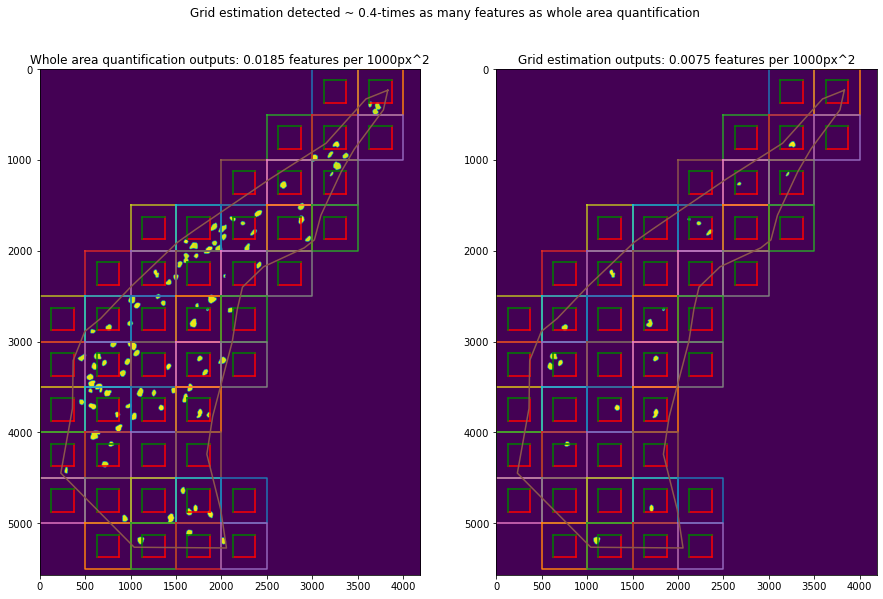

In [41]:
mask_max_projection = np.max(mask_zstack, axis=0)
quantification_mask_max_projection = np.max(mask_zstack_to_quantify_for_grid_estimation, axis=0)

fig = plt.figure(figsize=(15,17))
gs = fig.add_gridspec(1, 2)

fig.add_subplot(gs[0, 0])
plt.imshow(mask_max_projection)
for tile in overlapping_tiles:
    plt.plot(tile.bounding_box_x_for_plotting, tile.bounding_box_y_for_plotting)
    for i in range(2):
        plt.plot(tile.counting_square.exclusion_sides_as_lines[i].xy[1], tile.counting_square.exclusion_sides_as_lines[i].xy[0], c='red')
        plt.plot(tile.counting_square.inclusion_sides_as_lines[i].xy[1], tile.counting_square.inclusion_sides_as_lines[i].xy[0], c='green')
plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0])
plt.title(f'Whole area quantification outputs: {round(features_per_area*1000, 4)} features per 1000px^2')

fig.add_subplot(gs[0, 1])
plt.imshow(quantification_mask_max_projection)
for tile in overlapping_tiles:
    plt.plot(tile.bounding_box_x_for_plotting, tile.bounding_box_y_for_plotting)
    for i in range(2):
        plt.plot(tile.counting_square.exclusion_sides_as_lines[i].xy[1], tile.counting_square.exclusion_sides_as_lines[i].xy[0], c='red')
        plt.plot(tile.counting_square.inclusion_sides_as_lines[i].xy[1], tile.counting_square.inclusion_sides_as_lines[i].xy[0], c='green')
plt.plot(area_roi.boundary.xy[1], area_roi.boundary.xy[0])
plt.title(f'Grid estimation outputs: {round(features_per_area_grid*1000, 4)} features per 1000px^2')

plt.suptitle(f'Grid estimation detected ~ {round(features_per_area_grid/features_per_area, 2)}-times as many features as whole area quantification', y=0.76)

plt.show()